In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm, BatchNorm1d
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as T
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, global_mean_pool
from torch_geometric.utils import remove_self_loops
from torch.nn.utils import clip_grad_norm_

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score
import random
from statistics import mean

In [3]:
# Read from csv
precut_sig_df = pd.read_csv('Dijet_bb_pt20_50_dw.csv')
precut_bkg_df = pd.read_csv('Dijet_qq_pt20_50_dw.csv')

In [4]:
sig_df = precut_sig_df
bkg_df = precut_bkg_df

In [5]:
# Distinguish signal and background
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Separate Jet 0 and Jet 1 data
sig_jet0 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_jet0 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

sig_jet1 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet1|IsB")]]
bkg_jet1 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet1|IsB")]]

# Combine signal and background and shuffle
train_df = pd.concat([sig_jet0, bkg_jet0]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([sig_jet1, bkg_jet1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
def train_make_cuts(train_df, test_df):
    train_cut_df = train_df.copy()
    test_cut_df = test_df.copy()
    
    train_cut_df_sig = train_cut_df[(train_cut_df['IsB'] == 1) & (train_cut_df['Jet0_MC_Match'] == 1) & (train_cut_df['Jet0_MC_Jet_EfB'] > 0.6)]
    train_cut_df_bkg = train_cut_df[(train_cut_df['IsB'] == 0) & (train_cut_df['Jet0_MC_Match'] == 1) & (train_cut_df['Jet0_MC_Jet_EfB'] < 0.6) & (train_cut_df['Jet0_MC_Jet_EfD'] < 0.6)]

    test_cut_df_sig = test_cut_df[(test_cut_df['IsB'] == 1) & (test_cut_df['Jet1_MC_Match'] == 1) & (test_cut_df['Jet1_MC_Jet_EfB'] > 0.6)]
    test_cut_df_bkg = test_cut_df[(test_cut_df['IsB'] == 0) & (test_cut_df['Jet1_MC_Match'] == 1) & (test_cut_df['Jet1_MC_Jet_EfB'] < 0.6) & (test_cut_df['Jet1_MC_Jet_EfD'] < 0.6)]
    
    train_cut_df = pd.concat([train_cut_df_sig, train_cut_df_bkg], ignore_index=True)
    test_cut_df = pd.concat([test_cut_df_sig, test_cut_df_bkg], ignore_index=True)
    return train_cut_df, test_cut_df

In [7]:
train_cut_df, test_cut_df = train_make_cuts(train_df, test_df)

In [8]:
# Cut out some data for quicker runs
train_cut_df = pd.concat([train_cut_df.head(1000), train_cut_df.iloc[100000:101000]]) 
test_cut_df = pd.concat([test_cut_df.head(1000), test_cut_df.iloc[100000:101000]])

In [9]:
train_df = train_cut_df
test_df = test_cut_df

In [10]:
train_df.Jet0_nmuons

0         0
1         1
2         0
3         0
4         0
         ..
100995    0
100996    0
100997    1
100998    0
100999    0
Name: Jet0_nmuons, Length: 2000, dtype: int64

In [11]:
# Print some results to verify
print("Training set:")
print(train_df[['IsB', 'Jet0_nDaughters', 'Jet0_MC_Match', 'Jet0_MC_Jet_EfB', 'Jet0_MC_Jet_EfD']].head())
print("\nTest set:")
print(test_df[['IsB', 'Jet1_nDaughters', 'Jet1_MC_Match', 'Jet1_MC_Jet_EfB', 'Jet1_MC_Jet_EfD']].head())

Training set:
   IsB  Jet0_nDaughters  Jet0_MC_Match  Jet0_MC_Jet_EfB  Jet0_MC_Jet_EfD
0    1               12              1         0.928622              0.0
1    1               13              1         0.875273              0.0
2    1               18              1         0.912982              0.0
3    1               26              1         0.785623              0.0
4    1               16              1         0.791983              0.0

Test set:
   IsB  Jet1_nDaughters  Jet1_MC_Match  Jet1_MC_Jet_EfB  Jet1_MC_Jet_EfD
0    1               15              1         0.946420              0.0
1    1               18              1         0.713616              0.0
2    1               13              1         0.901948              0.0
3    1               11              1         0.936195              0.0
4    1               10              1         0.863696              0.0


In [12]:
# Duplicate data to lists matching the number of daughters/ nodes per jet/ row
def duplicate(df, cols, n_col):
    for col in cols:
        df[col] = df.apply(lambda row: [row[col]] * row[n_col] if isinstance(row[col], (float, int, list)) else row[col], axis=1)
    return df

# Convert string values into list of floats
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

# Create node feature array: [jet][daughter][feature]
def node_features(df, features_cols):
    features_list = []
    
    for _, row in df.iterrows():

        max_nodes = max(len(row[col]) if isinstance(row[col], list) else 1 for col in features_cols)
        jet_nodes = [[] for _ in range(max_nodes)]
        
        for column in features_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(max_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)

Data preprocessing

In [13]:
# Track/ daughter kinematic features
train_d_cols = [col for col in train_df.columns if "_Daughters" in col]
test_d_cols = [col for col in test_df.columns if "_Daughters" in col]

# Jet input features
train_jet_cols = ['Jet0_Eta', 'Jet0_PT', 'Jet0_nmuons', 'Jet0_muon_ProbNNMu', 'Jet0_muon_IPchi2']
test_jet_cols = ['Jet1_Eta', 'Jet1_PT', 'Jet1_nmuons', 'Jet1_muon_ProbNNMu', 'Jet1_muon_IPchi2']

# Features columns (daughter kinematics + Eta and pT)
train_f_cols = train_d_cols + train_jet_cols
test_f_cols = test_d_cols + test_jet_cols

# Duplicate single features for each node and convert strings into float lists
train_df = duplicate(train_df, ['Jet0_Eta', 'Jet0_PT', 'Jet0_muon_ProbNNMu', 'Jet0_muon_IPchi2'], 'Jet0_nDaughters')
test_df = duplicate(test_df, ['Jet1_Eta', 'Jet1_PT', 'Jet1_muon_ProbNNMu', 'Jet1_muon_IPchi2'], 'Jet1_nDaughters')

train_df = convert_to_lists(train_df, train_d_cols)
test_df = convert_to_lists(test_df, test_d_cols)

# Shuffle data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [14]:
train_features = node_features(train_df, train_f_cols)

Test - create gaussian distribution around 10 for background and 25 for signal (std = 5) to see if it picks up on it

In [343]:
# Create Gauss values for each daughter based on IsB column

def generate_gaussian(mean, std_dev):
    return random.gauss(mean, std_dev)

def generate_gaussian_list(row, mean1, mean2, std_dev):
    num_daughters = int(row['Jet0_nDaughters'] if 'Jet0_nDaughters' in row else row['Jet1_nDaughters'])
    mean = mean1 if row['IsB'] == 1 else mean2
    return [generate_gaussian(mean, std_dev) for _ in range(num_daughters)]

# Apply the function to create the new 'Gauss' column
train_df['Gauss'] = train_df.apply(lambda row: generate_gaussian_list(row, 10, 25, 5), axis=1)
test_df['Gauss'] = test_df.apply(lambda row: generate_gaussian_list(row, 10, 25, 5), axis=1)

# Print some results to verify
print("Training set:")
print(train_df[['IsB', 'Jet0_nDaughters', 'Gauss']].head())
print("\nTest set:")
print(test_df[['IsB', 'Jet1_nDaughters', 'Gauss']].head())

Training set:
   IsB  Jet0_nDaughters                                              Gauss
0    1               12  [13.910719184201584, 4.440898402546462, 14.817...
1    1               28  [11.514059215199739, 7.486849240581351, 11.234...
2    1               17  [6.997267551217277, 16.19551794744174, 10.2993...
3    1               13  [9.664431453480194, 14.942646185535029, 10.489...
4    0               12  [28.66824300346258, 17.44627756821771, 25.8531...

Test set:
   IsB  Jet1_nDaughters                                              Gauss
0    1               15  [15.918858842335975, 13.899850779520325, 7.878...
1    0               12  [26.869491040129486, 23.82645547594648, 34.120...
2    1               24  [5.434829782939187, 17.52027390757799, 13.6419...
3    1                9  [9.885772915678881, 7.867739207947798, 18.5882...
4    1               14  [16.409454265807845, -0.6419130756176035, 10.1...


In [430]:
features_list = node_features(train_df, train_f_cols)

In [19]:
import torch
from torch_geometric.data import Data
import networkx as nx  # For creating fully connected edges
from torch.utils.data import DataLoader
import pandas as pd

def create_data_objects(df, features_array):
    data_objects = []
    
    for idx, jet_features in enumerate(features_array):
        num_classes = 2  # binary classification
        
        x_list = []
        for feature_idx, feature_column in enumerate(jet_features):
            if isinstance(feature_column, list):
                # Flatten nested lists and handle single-level lists
                for i, value in enumerate(feature_column):
                    if isinstance(value, list):
                        for j, subvalue in enumerate(value):
                            x_list.append(torch.tensor([float(subvalue), feature_idx, i, j], dtype=torch.float).view(1, -1))
                    else:
                        x_list.append(torch.tensor([float(value), feature_idx, i, 0], dtype=torch.float).view(1, -1))
            elif not isinstance(feature_column, list):
                # Handle single values
                x_list.append(torch.tensor([[float(feature_column), feature_idx, 0, 0]], dtype=torch.float))
        
        # Concatenate tensors in x_list to form the node features x
        x = torch.cat(x_list, dim=0)
        num_nodes = x.size(0)
        
        # Fully connected edges
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()
        
        # Assuming 'IsB' column contains the binary class labels
        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        # Create a Data object for this jet
        data = Data(x=x, edge_index=edge_index, y=y)
        data_objects.append(data)
    
    return data_objects


def node_features(df, features_cols):
    features_list = []
    
    for _, row in df.iterrows():
        jet_features = []
        for column in features_cols:
            cell_value = row[column]
            jet_features.append(cell_value)
        
        features_list.append(jet_features)
    
    return features_list

# Extract node features
train_features = node_features(train_df, train_f_cols)
test_features = node_features(test_df, test_f_cols)

# Create graphs for each jet
train_data = create_data_objects(train_df, train_features)
test_data = create_data_objects(test_df, test_features)

# Load Data in batches using DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


KeyboardInterrupt: 

In [425]:
# original

# Create graphs for each jet
def create_data_objects(df, features_array):
    data_objects = []
    for idx, jet_features in enumerate(features_array):

        num_classes = 2 # binary classification
        x_list = []
        for feature_column in jet_features:
            if isinstance(feature_column, list) and feature_column:
                # Convert the list to a tensor
                feature_tensor = torch.tensor(feature_column, dtype=torch.float).view(-1, 1)
                x_list.append(feature_tensor)
            elif not isinstance(feature_column, list):
                # If it's a single value, convert it to a tensor with one element
                x_list.append(torch.tensor([[float(feature_column)]], dtype=torch.float))
        x = torch.stack(x_list)
        num_nodes = x.size(0)
        
        # Fully connected edges
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_classes=num_classes, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(train_df, train_f_cols)
test_features = node_features(test_df, test_f_cols)

# Create graphs for each jet
train_data = create_data_objects(train_df, train_features)
test_data = create_data_objects(test_df, test_features)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

RuntimeError: stack expects each tensor to be equal size, but got [15, 1] at entry 0 and [225, 1] at entry 29

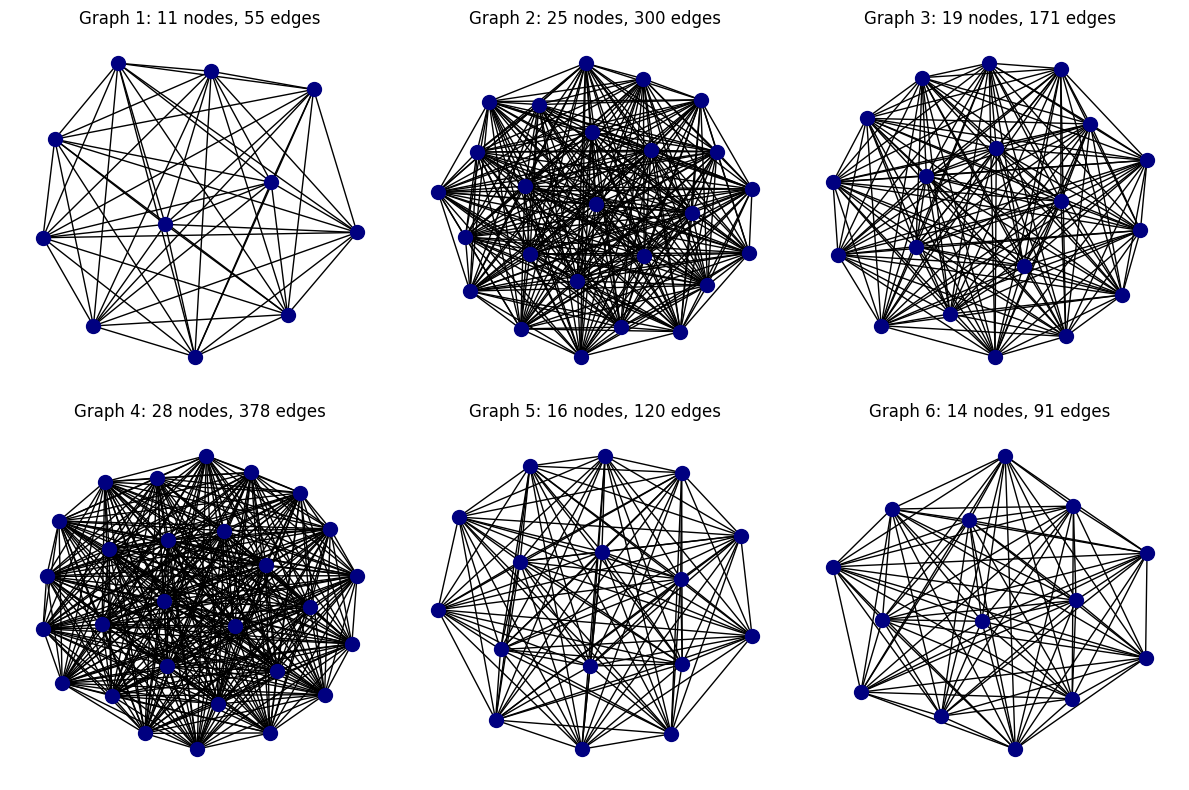

In [374]:
# Visualize some graphs
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, data in enumerate(train_loader.dataset[:6]):
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())

    nx.draw(G, ax=axes[i], node_color='navy', node_size=100)
    
    axes[i].set_title(f"Graph {i+1}: {data.num_nodes} nodes, {data.edge_index.size(1)} edges")

plt.tight_layout()
plt.show()

In [380]:
for data in train_loader:
    print(f"x shape: {data.x[0]}") # [num_nodes, num_features]
    print(f"edge_index shape: {data.edge_index.shape[0]}") # [2, num_edges] fully connected
    print(f"y: {data.y[0]}") # labels
    print(f"y shape: {data.y.shape[0]}")
    print(f"batch shape: {data.batch.shape[0]}") #num nodes in this batch
    print("###########################################")

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 54 but got size 68 for tensor number 1 in the list.

In [378]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels=64
        self.conv1 = GraphConv(len(train_f_cols), hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        x = self.dropout(x)
        
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x.squeeze(1)

model = GNN()

In [379]:
# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
criterion = nn.BCEWithLogitsLoss()
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
    return total_correct / total_samples

# Check gradients (exploding or vanishing)
def check_gradients():
    model.train()
    data = next(iter(train_loader))
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = criterion(out.squeeze(-1), data.y.float())
    loss.backward()

    print(' ')
    print('Grad norms:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                print(f"    {name}: {grad_norm:.6f}")

num_epochs = 25
loss_values = []
train_acc_values = []
test_acc_values = []

for epoch in range(num_epochs):
    loss = train()
    loss_values.append(loss)
    train_acc = test(train_loader)
    train_acc_values.append(train_acc)
    test_acc = test(test_loader)
    test_acc_values.append(test_acc)

    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    #scheduler.step(train_loss)

check_gradients()

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 62 but got size 46 for tensor number 1 in the list.

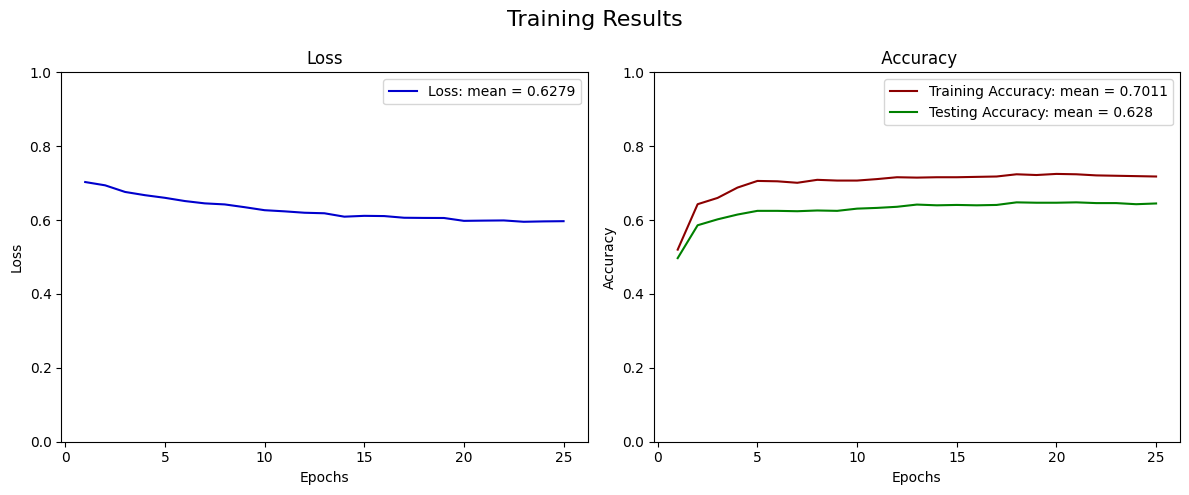

In [265]:
# Plot Loss and Accuracy
def plot_training_results(loss_values, train_acc_values, test_acc_values):
    epochs = range(1, len(loss_values) + 1)  # Create a list of epoch numbers
    mean_train_acc = mean(train_acc_values)
    mean_test_acc = mean(test_acc_values)
    mean_loss = mean(loss_values)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, loss_values, color='mediumblue', label=(f"Loss: mean = {mean_loss:.4f}"))
    ax1.set_ylim(0, 1)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy: mean = {mean_train_acc:.4f}"))
    ax2.plot(epochs, test_acc_values, color='green', label=(f"Testing Accuracy: mean = {mean_test_acc:.4}"))
    ax2.set_ylim(0, 1)
    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

# After your training loop, call the function:
plot_training_results(loss_values, train_acc_values, test_acc_values)


Compute ROC Curve and AUC

In [271]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [274]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

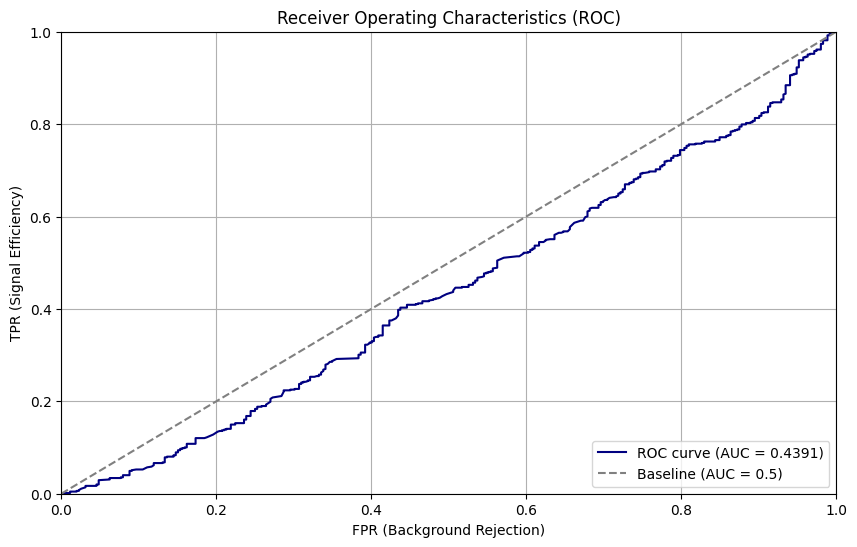

In [304]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('TPR (Signal Efficiency)')
plt.xlabel('FPR (Background Rejection)')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()